# pyxem


### A 4-D STEM Package in the Hyperspy Ecosystem

#### Carter Francis, University of Wisconsin Madison
#### *June 13, 2023*

# Outline

1. Introduction to 4D STEM and pyxem
2. Loading and Working with Data
3. Example workflows
4. Other features available 
5. Scaling pyxem (and hyperspy) to multi TB sized datasets

# 4-D STEM Rich in Information (and in Size)

<img src="Images/4DSTEM.gif" alt="4D STEM GIF">

# Using pyxem 

Because pyxem integrates with hyperspy importing hyperspy will automatically load pyxem if it is installed. We can load and visualize the same dataset 

In [9]:
import hyperspy.api as hs
hs.set_log_level("ERROR")

In [10]:
# setting the plotting backend
# ctrl+enter
%matplotlib widget    
import matplotlib.pyplot as plt
plt.style.use('dark_background') #lets use dark mode just for fun :)
dp = hs.load("data/mgo_nanoparticles.zspy") # Use Zarr backend for speed and load lazily cause we can
dp.plot()

# Pyxem Dependacy (Family) Tree

<img src="Images/familyTree.svg" alt="Dependancy Tree">

# Extending Hyperspy's Capabilities

Pyxem works _with_ hyperspy to manage very large datasets. In order to acomplish this pyxem makes heavy use of:

- Lazy operations including lazy loading of data and lazy plotting
- Efficient loading of data from file (using primarily the .zarr file specificiation)
- Scalibility through Dask allowing running on a single core to running distributed clustering computing

All together pyxem offers _fast_ scalable performance across the board paired with the great tools for visualization offered through hyperspy

<center>
<img src="Images/zarr-pink-horizontal.svg" alt="ZARR" width="300" height="300">  <img src="Images/dask_horizontal.svg" alt="DASK" width="300" height="300" ></center>

## Creating Virtual Images
We can construct Virtual images very easily (and interactively using widgets)

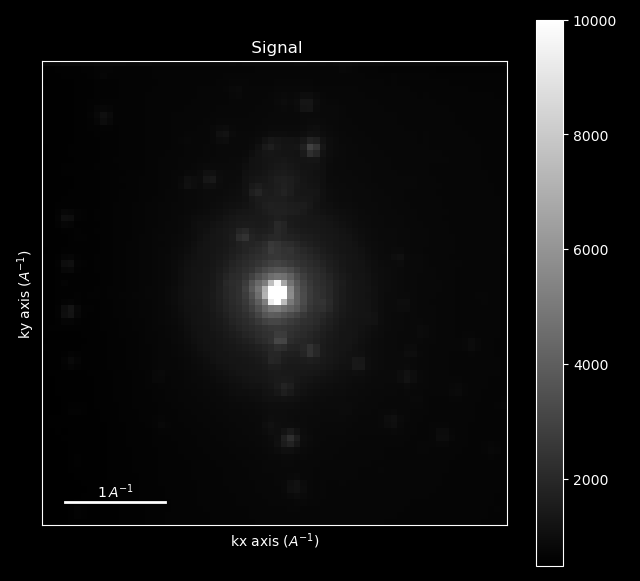

In [11]:
#press ctr-enter to run cell!
mean_cbed = dp.mean() # get the mean diffraction pattern
mean_cbed.plot(vmax=10000) # plot the mean diffraction pattern
bf_roi = hs.roi.CircleROI(cx=0, cy=0, r= 0.2) # create a Brightfield ROI
bf_roi.add_widget(mean_cbed) # add roi to plot 

# Try moving around the Interactive Widget!

### You can grab the squares to move the ROI

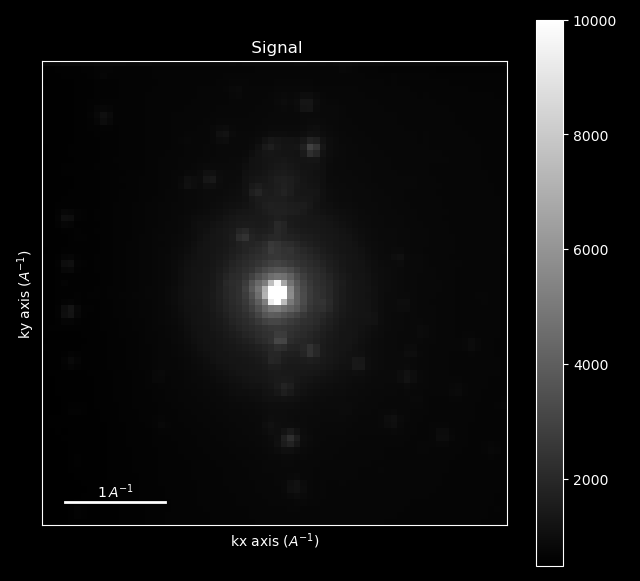

In [5]:
#press ctr+enter to run! 
mean_cbed.plot(vmax=10000) # plot the mean diffraction pattern
df_roi = hs.roi.CircleROI(cx=0, cy=0, r_inner= 0.4, r=2.) #create a Darkfield ROI
df_roi.add_widget(mean_cbed) # add roi to plot

## Make Virtual Diffraction Patterns

[<Axes: title={'center': 'Virtual Bright Field'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <Axes: title={'center': 'Virtual Dark Field'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>]

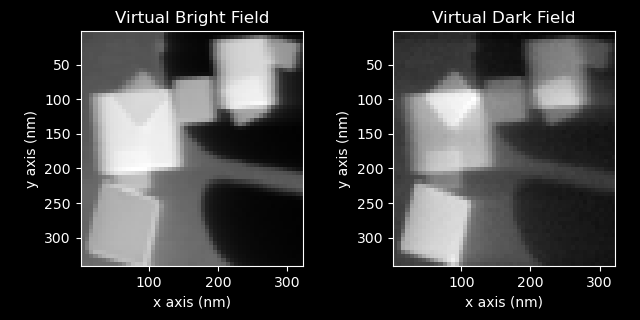

In [6]:
import matplotlib.pyplot as plt
bf = dp.get_integrated_intensity(bf_roi) # integrate the BF ROI
df =  dp.get_integrated_intensity(df_roi) # integrate the DF ROI
display(hs.plot.plot_images([bf, df], label=["Virtual Bright Field", "Virtual Dark Field"], tight_layout=True, colorbar=None)) # Plot both ROI's using hyperspy

# Finding Peaks in 2D 

- Hyperspy also has function for finding features in 2 dimensions. 
- Lets look at the find_peaks function!

In [7]:
import numpy as np
dp_sliced = dp.inav[20:30,20:30]
slic_max = np.max(dp_sliced.data)
dp_sliced = dp_sliced/slic_max * 20
pks = dp_sliced.find_peaks(method="local_max",
                           threshold_abs=10,
                           min_distance=3)

## Converting the Peaks to Pyxem Diffraction Vector

In [13]:
from pyxem.signals import DiffractionVectors
import numpy as np

pks = dp.find_peaks(interactive=False, 
                    method="local_max",
                    threshold_abs=1.6*slic_max/20,
                    min_distance=3)
dv = DiffractionVectors.from_peaks(peaks=pks,
                                   center=np.array(dp.axes_manager.signal_shape)/2-.5,
                                   calibration=dp.axes_manager.signal_axes[0].scale)

[########################################] | 100% Completed | 2.66 ss
[########################################] | 100% Completed | 101.14 ms


# Visualizing The Peaks

In [15]:
%matplotlib widget
from pyxem.signals.diffraction_vectors import generate_marker_inputs_from_peaks
xx,yy = generate_marker_inputs_from_peaks(dv)
dp.plot(vmax=4000)
for x,y in zip(xx,yy):
    m = hs.plot.markers.Point(y,x, color="r", size=200, )
    dp.add_marker(m, plot_marker=True, permanent=False,)

[########################################] | 100% Completed | 101.08 ms


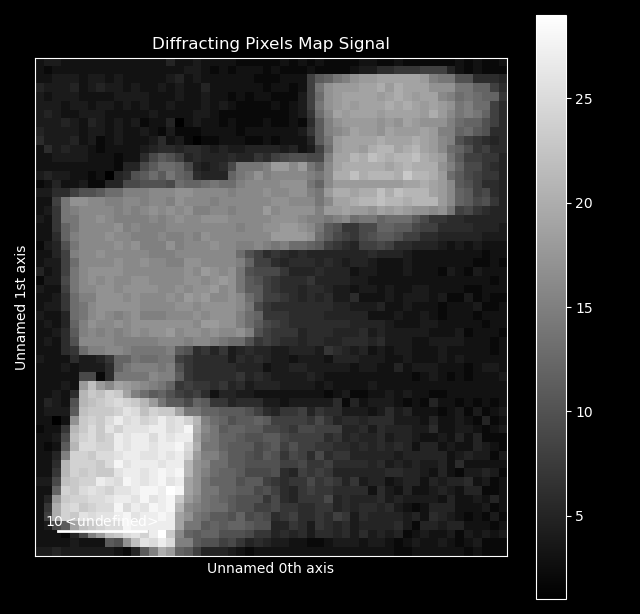

In [16]:
dv.get_diffracting_pixels_map().plot()

# Clustering the Diffraction Vectors 

In [17]:
distance_threshold = 0.1
min_samples = 7

unique_peaks = dv.get_unique_vectors(method='DBSCAN',
                                     distance_threshold=distance_threshold,
                                     min_samples=min_samples)
print(np.shape(unique_peaks.data)[0], ' unique vectors were found.')

unique_peaks = unique_peaks.filter_magnitude(min_magnitude=.4,
                                   max_magnitude=np.inf)
print(np.shape(unique_peaks)[0], ' unique vectors.')

61  unique vectors were found.
60  unique vectors.


## Plotting the Clustered Diffraction Vector

Try to moving the maker over the indentified spots to make virtual images!

In [20]:
%matplotlib widget
dpt = dp.T
dpt.plot()
for x,y in zip(unique_peaks.data[:,1],unique_peaks.data[:,0]):
    markers = hs.plot.markers.Point(x= x,y=y, color="r")
    dpt.add_marker(markers, plot_on_signal=False)

## Making Virtual Images from the Vectors

In [24]:
from pyxem.generators import VirtualDarkFieldGenerator
radius=0.1
vdfgen = VirtualDarkFieldGenerator(dp, unique_peaks) 
VDFs = vdfgen.get_virtual_dark_field_images(radius=radius)
VDFs

<VirtualDarkFieldImage, title: Stack of Integrated intensity, dimensions: (60|54, 57)>

## Plotting the Virtual Images

In [25]:
VDFs.plot()

## Lazy Data in Pyxem
1. Allows you to operate on datasets larger than available memory 
2. Increases parallelism
3. Allows you to split operations easily across many machienes
4. Simplifies and speeds up your workflows. 

## Using a distributed backend

Pyxem integrates with `dask` to bring parallel and fast operations

```python 
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client
```

or running through a scheduler:

```python 
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=8,
                       processes=4,
                       memory="16GB",
                       account="woodshole",
                       walltime="01:00:00",
                       queue="normal")

cluster.scale(jobs=10) # scale to 10 jobs
client = Client(cluster) # connect to cluster
```

# The Beauty of Streaming Data

- Same workflow for 10 Gb to 10 Tb
- No dependacy on RAM
- Loading Data from disk and transfer is ___No Lognger Slow___
- We routinely see ~30Gb/sec i-o from spinning disks! 
- That means that we can theoretically process a 1 Tb dataset in ~ 1 minute